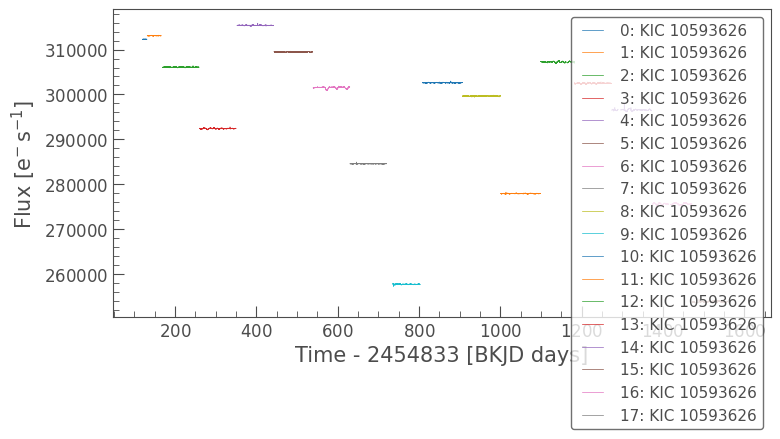

In [ ]:
import lightkurve as lk
%matplotlib inline
# Search for Kepler observations of Kepler-69
search_result = lk.search_lightcurve('Kepler-22', author='Kepler', cadence='long')
# Download all available Kepler light curves
lc_collection = search_result.download_all()
lc_collection.plot(); 


<Axes: xlabel='Time - 2454833 [BKJD days]', ylabel='Normalized Flux'>

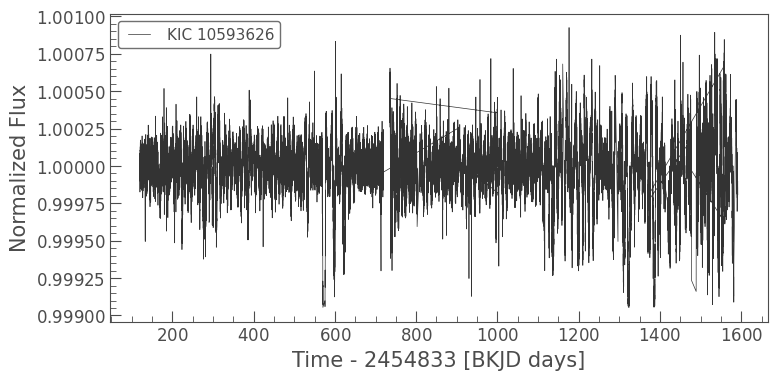

In [ ]:
lc = lc_collection.stitch().flatten(window_length=901).remove_outliers()
lc.plot() #LOAD THE TIME SERIES 

In [ ]:
lc #This is the entire data 

time,flux,flux_err,quality,timecorr,centroid_col,centroid_row,cadenceno,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,sap_quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,,,,d,pix,pix,,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
Time,float64,float64,int32,float32,float64,float64,int32,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
120.53900742435508,1.0000801e+00,4.8354697e-05,0,8.550044e-04,179.91579,615.85341,568,3.1178103e+05,1.5097328e+01,2.8354380e+03,1.3012959e+00,3.1230866e+05,1.5100382e+01,0,———,———,———,———,179.91579,6.9586677e-05,615.85341,5.4353437e-05,-1.4607409e-03,3.5337068e-03
120.55944174409524,9.9997437e-01,4.8534574e-05,0,8.557241e-04,179.91600,615.85347,569,3.1175097e+05,1.5096919e+01,2.8441611e+03,1.3040152e+00,3.1227566e+05,1.5156554e+01,0,———,———,———,———,179.91600,6.9587884e-05,615.85347,5.4360149e-05,-1.1929076e-03,3.6978703e-03
120.57987596383464,1.0000850e+00,4.8572474e-05,0,8.564438e-04,179.91604,615.85321,570,3.1177844e+05,1.5098232e+01,2.8446782e+03,1.3008099e+00,3.1231019e+05,1.5168389e+01,0,———,———,———,———,179.91604,6.9586698e-05,615.85321,5.4356773e-05,-1.0024284e-03,3.5327603e-03
120.60031038356829,9.9982530e-01,4.8263319e-05,10000000,8.571636e-04,179.91653,615.85324,571,3.1173134e+05,1.5096980e+01,2.8429888e+03,1.3055528e+00,3.1222909e+05,1.5071846e+01,10000000,———,———,———,———,179.91653,6.9590933e-05,615.85324,5.4356849e-05,-5.6158245e-04,3.3443142e-03
120.62074470325024,1.0000035e+00,4.8561029e-05,0,8.578832e-04,179.91669,615.85288,572,3.1176266e+05,1.5098287e+01,2.8425586e+03,1.3027847e+00,3.1228475e+05,1.5164816e+01,0,———,———,———,———,179.91669,6.9593836e-05,615.85288,5.4362863e-05,-2.9510944e-04,3.3509261e-03
120.64117892293143,9.9993354e-01,4.8336111e-05,0,8.586029e-04,179.91674,615.85278,573,3.1176109e+05,1.5097275e+01,2.8402161e+03,1.3063352e+00,3.1226291e+05,1.5094578e+01,0,———,———,———,———,179.91674,6.9586386e-05,615.85278,5.4350247e-05,-8.1684761e-05,2.9048885e-03
120.66161324260611,9.9991506e-01,4.8395952e-05,10000000,8.593226e-04,179.91680,615.85293,574,3.1174666e+05,1.5097007e+01,2.8430410e+03,1.3027490e+00,3.1225712e+05,1.5113265e+01,10000000,———,———,———,———,179.91680,6.9589340e-05,615.85293,5.4359112e-05,1.0091478e-04,3.1171264e-03
120.68204766223062,9.9997467e-01,4.8363574e-05,0,8.600422e-04,179.91684,615.85280,575,3.1177031e+05,1.5097208e+01,2.8382690e+03,1.3019427e+00,3.1227575e+05,1.5103154e+01,0,———,———,———,———,179.91684,6.9583992e-05,615.85280,5.4353870e-05,9.1682872e-05,2.9421994e-03


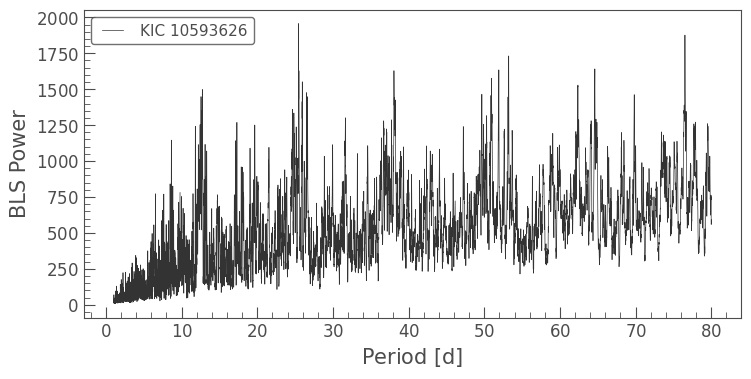

In [11]:
import numpy as np
# Create array of periods to search
period = np.linspace(1, 80, 10000)
# Create a BLSPeriodogram
bls = lc.to_periodogram(method='bls', period=period, frequency_factor=500);
bls.plot();
#Power vs Period 

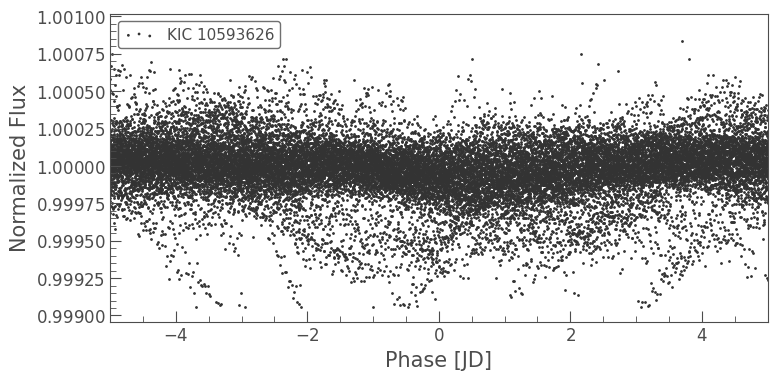

In [12]:
planet_b_period = bls.period_at_max_power
planet_b_t0 = bls.transit_time_at_max_power
planet_b_dur = bls.duration_at_max_power
ax = lc.fold(period=planet_b_period, epoch_time=planet_b_t0).scatter()
bls.frequency_at_max_power
ax.set_xlim(-5, 5);

#Generate Time Series


Error in callback <function _draw_all_if_interactive at 0x14674e160> (for post_execute):


KeyboardInterrupt: 

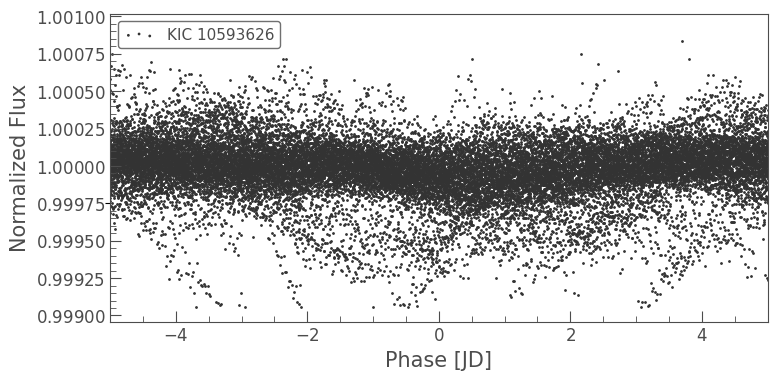

In [13]:
ax = lc.fold(period=planet_b_period, epoch_time=planet_b_t0).scatter()
ax.set_xlim(-5, 5);

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS

# Assume you have loaded your real data into `time` and `flux`
# Example: time = np.array([...]), flux = np.array([...])
flux = bls.flux.value  # Assuming these are NumPy arrays
time = bls.time.value

# Convert NumPy arrays to PyTorch tensors
time_tensor = torch.from_numpy(time).float()
flux_tensor = torch.from_numpy(flux).float()

# Define the model
def model(time, flux):
    # Priors for unknown parameters
    period = pyro.sample('period', dist.Uniform(0.5, 30))
    t0 = pyro.sample('t0', dist.Uniform(0, period))
    duration = pyro.sample('duration', dist.Uniform(0.01, 0.5))
    depth = pyro.sample('depth', dist.Uniform(0, 0.02))

    # Model for the transit light curve
    phase = ((time - t0 + 0.5 * period) % period) - 0.5 * period
    in_transit = (phase.abs() < (duration / 2)).float()
    expected_flux = 1 - depth * in_transit
    
    # Likelihood (assuming Gaussian noise)
    sigma = pyro.sample('sigma', dist.HalfNormal(0.001))
    with pyro.plate('data', len(time)):
        pyro.sample('obs', dist.Normal(expected_flux, sigma), obs=flux)

# Set up and run MCMC
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=100, warmup_steps=30)
mcmc.run(time_tensor, flux_tensor)

# Print summary of MCMC results
mcmc.summary()

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Warmup:  14%|█▍        | 18/130 [00:09,  1.10it/s, step size=2.24e-09, acc. prob=0.532]

KeyboardInterrupt: 

In [46]:
lc["flux_err"].value

MaskedNDArray([4.83546974e-05, 4.85345736e-05, 4.85724740e-05, ...,
               4.94470886e-05, 4.95152069e-05, 4.95195631e-05])

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import emcee

# Assuming you have these imported or defined elsewhere:
# `time_series` -> Time series data: a tuple (time, flux, flux_err)




# Example time-series data (replace with your actual data)
time = bls.time.value   # Time array
flux = bls.flux.value 
flux_err = lc["flux_err"].value

# Known parameters
period = 25.452945294529457  # Period of the planet in days
duration = 0.33  # Duration of the transit in days
depth = 0.0001074028110313094 # Depth of the transit


# Physical constants
G = 6.67430e-11  # Gravitational constant, m^3 kg^-1 s^-2
M_sun = 1.989e30  # Solar mass, kg
R_sun = 6.957e8  # Solar radius, m

# Stellar parameters (replace with actual values if known)
M_star = 1.0 * M_sun  # Mass of the star in kg
R_star = 1.0 * R_sun  # Radius of the star in meters


# Transit model
def transit_model(time, period, duration, depth):
    """
    Simple box transit model: assumes flat-bottom transit.
    """
    phase = (time % period) / period
    in_transit = (phase < (duration / period) / 2) | (phase > (1 - (duration / period) / 2))
    model_flux = np.ones_like(time)
    model_flux[in_transit] -= depth
    return model_flux


# Likelihood function
def log_likelihood(params, time, flux, flux_err):
    Mp = params[0]  # Planet mass
    # Derived semi-major axis using Kepler's third law
    a = ((G * M_star * (period * 86400) ** 2) / (4 * np.pi ** 2)) ** (1 / 3)
    # Relation between mass and radius (optional improvement: use empirical MR relation)
    R_p = (Mp / M_sun) ** (1 / 3) * R_sun

    model_flux = transit_model(time, period, duration, depth)
    residuals = flux - model_flux
    return -0.5 * np.sum((residuals / flux_err) ** 2)


# Prior function
def log_prior(params):
    Mp = params[0]  # Planet mass
    if 0.00001 * M_sun < Mp < 0.01 * M_sun:  # Reasonable bounds for planet mass
        return 0.0
    return -np.inf


# Posterior function
def log_posterior(params, time, flux, flux_err):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, time, flux, flux_err)


# Initial guesses
initial_mass_guess = 1/33333333 * M_sun
nwalkers = 32
ndim = 1

# Spread initial positions randomly within a range (e.g., prior bounds)
initial_pos = np.random.uniform(
    low=0.1 * M_sun, high=10.0 * M_sun, size=(nwalkers, ndim)
)

# Set up MCMC sampler
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_posterior, args=(time, flux, flux_err)
)

# Burn-in phase
print("Running burn-in...")
n_burn = 500
pos, prob, state = sampler.run_mcmc(initial_pos, n_burn, progress=True)

# Reset sampler and run production
print("Running production...")
sampler.reset()
n_steps = 10000
sampler.run_mcmc(pos, n_steps, progress=True)

# Analyze results
samples = sampler.get_chain(flat=True)
mass_samples = samples[:, 0]

# Plot the posterior distribution
plt.figure(figsize=(8, 6))
plt.hist(mass_samples, bins=50, density=True, alpha=0.7, color="blue")
plt.xlabel("Planet Mass (kg)")
plt.ylabel("Probability Density")
plt.title("Posterior Distribution of Planet Mass")
plt.show()

# Print summary statistics
mass_median = np.median(mass_samples)
mass_std = np.std(mass_samples)
print(f"Estimated planet mass: {mass_median:.2e} kg ± {mass_std:.2e} kg")

Running burn-in...


100%|██████████| 500/500 [00:00<00:00, 1639.16it/s]


Running production...


100%|██████████| 10000/10000 [00:33<00:00, 298.91it/s]

Estimated planet mass: 1.00e+31 kg ± 7.25e+30 kg



/var/folders/wr/p4g_vhcn34g6101bsy9rmsd40000gn/T/ipykernel_57493/687447146.py:109: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [62]:
import numpy as np
import matplotlib.pyplot as plt
import batman
import emcee

# Known constants and parameters
G = 6.67430e-11  # Gravitational constant, m^3 kg^-1 s^-2
M_sun = 1.989e30  # Solar mass, kg
R_sun = 6.957e8  # Solar radius, m

# Known stellar parameters (replace with actual values)
M_star = 1.0 * M_sun  # Stellar mass, kg
R_star = 1.0 * R_sun  # Stellar radius, m

time = bls.time.value   # Time array
flux = bls.flux.value 
flux_err = lc["flux_err"].value

# Known parameters
period = 25.452945294529457  # Period of the planet in days
duration = 0.33  # Duration of the transit in days
depth = 0.0001074028110313094 # Depth of the transit


# Define the transit model using BATMAN
def create_transit_model(params, time):
    """Create a transit model with BATMAN."""
    t0, a_Rs, incl, Rp_Rs = params
    # Set up BATMAN parameters
    bm_params = batman.TransitParams()
    bm_params.t0 = t0  # Time of transit center
    bm_params.per = period  # Orbital period
    bm_params.rp = Rp_Rs  # Planet-to-star radius ratio
    bm_params.a = a_Rs  # Semi-major axis in units of stellar radius
    bm_params.inc = incl  # Orbital inclination in degrees
    bm_params.ecc = 0.0  # Eccentricity (assumed circular)
    bm_params.w = 90.0  # Argument of periastron (irrelevant for circular orbit)
    bm_params.u = [0.3, 0.3]  # Limb darkening coefficients (quadratic)
    bm_params.limb_dark = "quadratic"  # Limb darkening model

    # Create model
    m = batman.TransitModel(bm_params, time)
    return m.light_curve(bm_params)


# Log-likelihood function
def log_likelihood(params, time, flux, flux_err):
    t0, a_Rs, incl, Rp_Rs = params
    model_flux = create_transit_model(params, time)
    residuals = flux - model_flux
    return -0.5 * np.sum((residuals / flux_err) ** 2)


# Log-prior function
def log_prior(params):
    t0, a_Rs, incl, Rp_Rs = params
    # Priors for parameters
    if 0.0 < t0 < period and 1.0 < a_Rs < 50.0 and 80.0 < incl < 90.0 and 0.01 < Rp_Rs < 0.2:
        return 0.0
    return -np.inf


# Log-posterior function
def log_posterior(params, time, flux, flux_err):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, time, flux, flux_err)


# Initial guesses for MCMC
nwalkers = 32
ndim = 4
initial_pos = [
    [0.5 * period, 10.0, 85.0, 0.1] + 1e-4 * np.random.randn(ndim) for _ in range(nwalkers)
]

# Set up MCMC sampler
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_posterior, args=(time, flux, flux_err)
)

# Burn-in phase
print("Running burn-in...")
n_burn = 500
pos, prob, state = sampler.run_mcmc(initial_pos, n_burn, progress=True)

# Reset sampler and run production
print("Running production...")
sampler.reset()
n_steps = 2000
sampler.run_mcmc(pos, n_steps, progress=True)

# Analyze results
samples = sampler.get_chain(flat=True)
t0_samples, a_Rs_samples, incl_samples, Rp_Rs_samples = samples.T

# Plot posterior distributions
import corner

labels = ["$t_0$", "$a/R_\\star$", "Inclination (deg)", "$R_p/R_\\star$"]
fig = corner.corner(samples, labels=labels, truths=[0.5 * period, None, 90.0, None])
plt.show()

# Summary statistics
t0_median = np.median(t0_samples)
a_Rs_median = np.median(a_Rs_samples)
incl_median = np.median(incl_samples)
Rp_Rs_median = np.median(Rp_Rs_samples)

print(f"t0: {t0_median:.3f} days")
print(f"a/R_star: {a_Rs_median:.3f}")
print(f"Inclination: {incl_median:.3f} degrees")
print(f"R_p/R_star: {Rp_Rs_median:.3f}")



Running burn-in...
emcee: Exception while calling your likelihood function:
  params: [12.72639817 10.00002425 84.99993692  0.10003587]
  args: (array([ 120.53900742,  120.55944174,  120.57987596, ..., 1590.96059791,
       1590.98103212, 1591.00146652]), MaskedNDArray([1.00008011, 0.99997437, 1.000085  , ..., 0.99984617,
               0.99980518, 0.99989669]), MaskedNDArray([4.83546974e-05, 4.85345736e-05, 4.85724740e-05, ...,
               4.94470886e-05, 4.95152069e-05, 4.95195631e-05]))
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.11/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wr/p4g_vhcn34g6101bsy9rmsd40000gn/T/ipykernel_57493/2106931348.py", line 68, in log_posterior
    return lp + log_likelihood(params, time, flux, flux_err)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wr/p4g_vhcn34g6101bsy9rmsd40000gn/T/ipykernel_57493/2106931348.py", line 49, in log_likelihood
    model_flux = create_transit_model(params, time)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wr/p4g_vhcn34g6101bsy9rmsd40000gn/T/ipykernel_57493/2106931348.py", line 30, in create_transit_model
    bm_params = batman.TransitParams()
                ^^^^^^^^^^^^^^^^^^^^
AttributeError: module 'batman' has no attribute 'TransitParams'


AttributeError: module 'batman' has no attribute 'TransitParams'